In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *

## create the databunch (dataset + dataloader)

In [2]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor()])

# if does not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32,shuffle=False)

## plot some random examples:

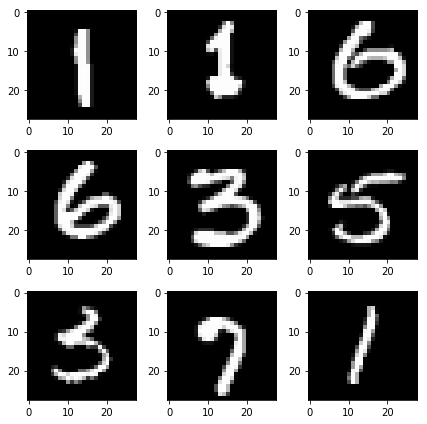

In [3]:
fig,ax = plt.subplots(3,3,figsize=(6,6))

for axlist in ax:
    for ax_i in axlist:
        idx = np.random.randint(len(train_set))
        img = train_set[idx][0]

        ax_i.imshow( img.data.numpy().reshape(28,28) ,cmap='gray')

plt.tight_layout()
plt.show()

## create a VAE model, with encoder, decoder, and a VAE that picks random latent representations from the encoders output

notice we define a nn.Module for the different parts (encoder, decoder) and then create a nn.Module VAE that has internal parts that are the encoder and decoder models we defined (and the VAE connects between them)

In [ ]:
latent_dim = 2

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        return self.fc21(out), self.fc22(out)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return self.sig(out)

In [15]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def pick_random_z(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def forward(self, x):
        
        
        mu, logvar = self.enc(x.view(-1, 784))
        
        z = self.pick_random_z(mu, logvar)
        
        return (self.dec(z),x, mu, logvar)


model = VAE()

## what does it look like before training?

if we pass a digit through our model, it predicts a random 28 by 28 matrix of values

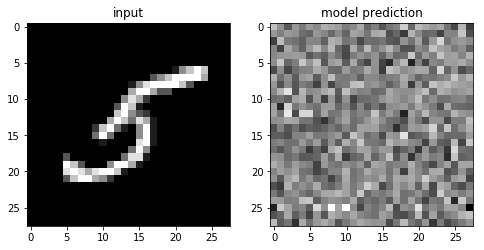

In [31]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

model.cpu()

img = train_set[35][0]


decoded = model(img)[0].data.numpy()


ax[0].imshow( img.data.numpy().reshape(28,28) ,cmap='gray')
ax[1].imshow( decoded.reshape(28,28) ,cmap='gray')
ax[0].set_title('input')
ax[1].set_title('model prediction')
plt.show()

## let's look at the distribution of encoding values for the untrained model on the test dataset

all the different digits are scattered around the 0,0 encoding value, no different between digits



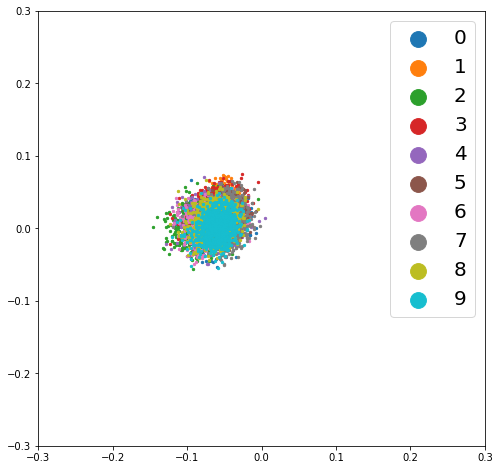

In [32]:
encoding = {}
encoding_std = {}

n_test = len(test_set)

for test_i in range(n_test):
    x,y = test_set[test_i]
    
    if y not in encoding:
        encoding[y] = []
        encoding_std[y] = []
        
    enc_mean, enc_std = model.enc(x.view(-1, 784))
    
    encoding[y].append( enc_mean.data.numpy()[0] )
    encoding_std[y].append( np.exp(0.5*enc_std.data.numpy()[0]) )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])
    encoding_std[key] = np.array(encoding_std[key])
    
    
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(figsize=(8,8))

for key in range(10):
    ax.scatter(encoding[key][:,0],encoding[key][:,1],label=str(key),s=5.5)

        
lgnd = ax.legend(fontsize=20)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [250]

ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.3)
plt.show()

## Now we will define a custom loss function

we have not done this before, always using standard loss functions like CrossEntropy, MSELoss, etc.

we can define our own function, as long as it take our target and network output, and outputs a single number


notice that in this specific case, we are doing something a bit unconventional, our dataset has labels for every digit (0 to 9) but we are not using it - our actual interest is the input image - we want the neural network to reconstruct the input image.

but working with fastai restricts us to the format of a loss function that is given the network output and the label of the dataset. so we pass the input image together with the neural network output, and just ignore the target digit label in the loss function

In [34]:
mse_l = nn.MSELoss(size_average=None, reduce=None, reduction='sum')


def loss_function(y_hat,y):
    
    recon_x, x, mu, logvar = y_hat
    
    
    MSE = mse_l(recon_x, x.view(-1, 784))

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

## a fastai databunch wraps the pytorch dataloader, and we give the learner our DataBunch, our model, AND our new loss function

In [35]:
db = DataBunch(train_dl=train_loader,valid_dl=test_loader,fix_dl=test_loader)


learn = Learner(db,model,loss_func=loss_function)

## now we train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


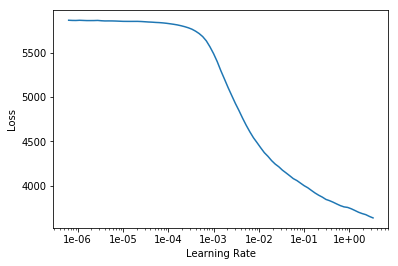

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(2,max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,1285.161377,1281.133057,00:15
1,1221.595093,1199.797241,00:14


## let's look at some predictions on the test set

since the we sample from the latent space based on the encoder output, I show multiple samples from each input. each one has a slightly different encoding

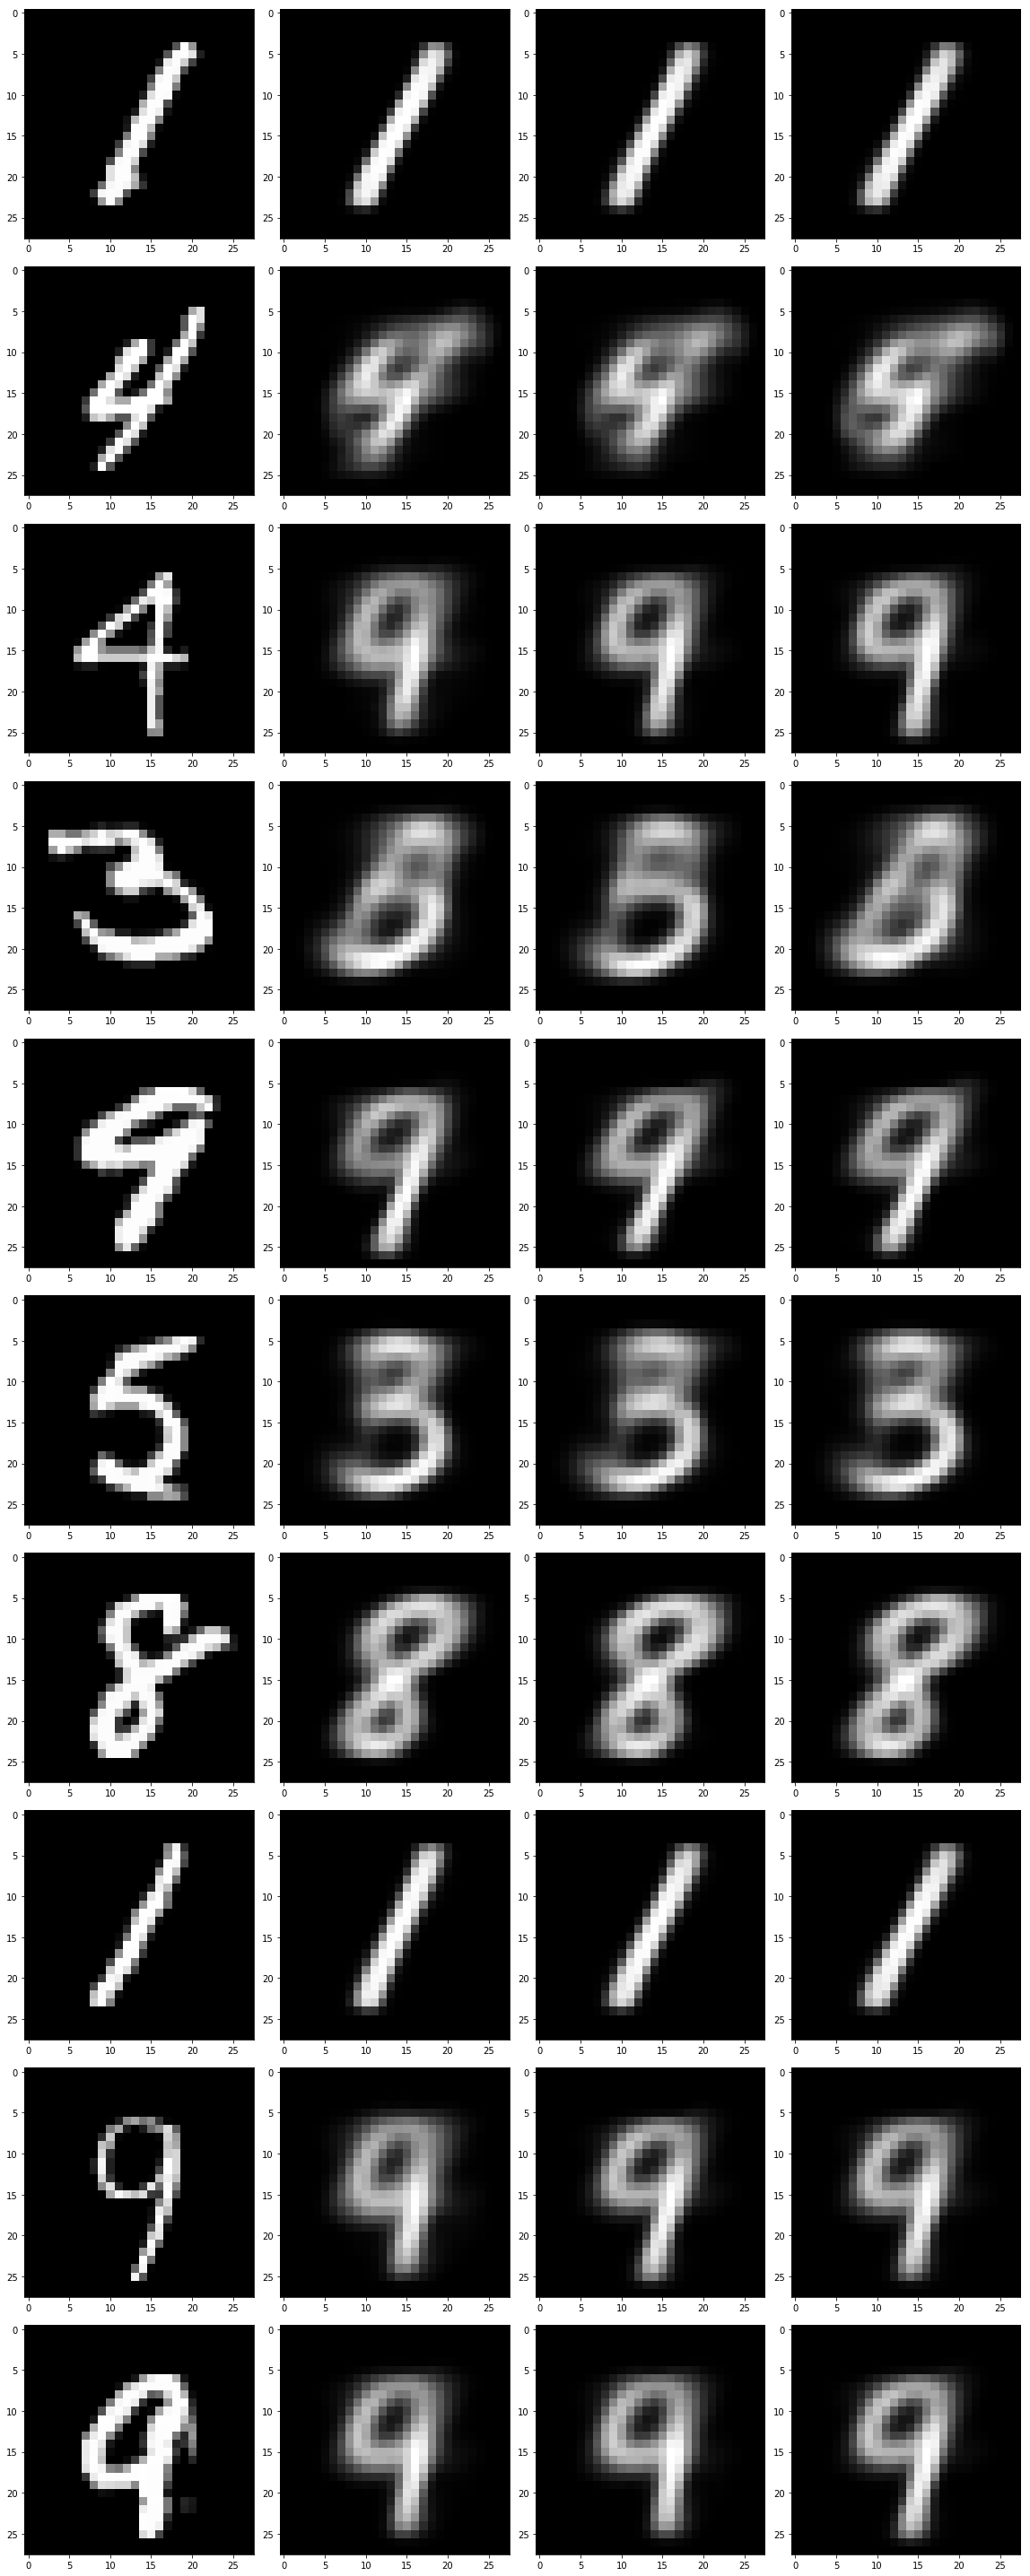

In [40]:
n_examples = 10
n_decoded = 3
fig,ax = plt.subplots(n_examples,1+n_decoded,figsize=(4+4*n_decoded,n_examples*4))

model.cpu()

for i in range(n_examples):
    idx = np.random.randint(len(test_set))

    img = test_set[idx][0]
    ax[i][0].imshow( img.data.numpy().reshape(28,28) ,cmap='gray')

    for dec_i in range(n_decoded):
        decoded = model(img)[0].data.numpy()
    
        ax[i][1+dec_i].imshow( decoded.reshape(28,28) ,cmap='gray')
        
plt.tight_layout()
plt.show()

## since we have a 2 dimensional encoding, it's easy to visualise

In [41]:
encoding = {}
encoding_std = {}

n_test = len(test_set)

for test_i in range(n_test):
    x,y = test_set[test_i]
    
    if y not in encoding:
        encoding[y] = []
        encoding_std[y] = []
        
    enc_mean, enc_std = model.enc(x.view(-1, 784))
    
    encoding[y].append( enc_mean.data.numpy()[0] )
    encoding_std[y].append( np.exp(0.5*enc_std.data.numpy()[0]) )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])
    encoding_std[key] = np.array(encoding_std[key])
    

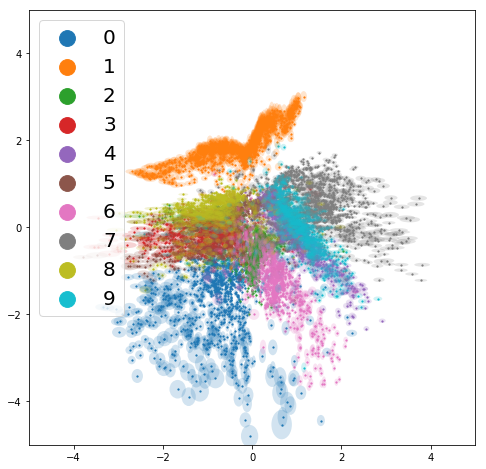

In [45]:
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(figsize=(8,8))

for key in range(10):
    sct = ax.scatter(encoding[key][:,0],encoding[key][:,1],label=str(key),s=1.5)
    for p in zip(encoding[key], encoding_std[key]):
        el = Ellipse(xy=p[0],width=p[1][0],height=p[1][1],angle=0)
        el.set_facecolor(sct.get_facecolor()[0])
        el.set_alpha(0.2)
        ax.add_artist(el)
        
        
lgnd = ax.legend(fontsize=20)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [250]


ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()

## we don't need an input image anymore, we can use any point in the latent space to generate an image

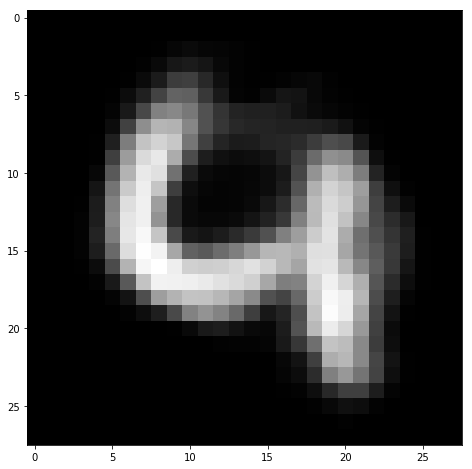

In [47]:
fig,ax = plt.subplots(figsize=(8,8))

model.cpu()

img = model.dec(torch.FloatTensor([4,-4]))


ax.imshow( img.data.numpy().reshape(28,28) ,cmap='gray')

## now let's build a decoder that outputs a distribution over X given Z

the difference compared to before is that the decoder does not output a 28 by 28 image, but 2 vectors of 784 representing the mean and variance of the pixels in a 28 by 28 picture, and in the VAE we sample the output image from those values to give the output image.

the rest of the training is the same

In [3]:
latent_dim = 2

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        return self.fc21(out), self.fc22(out)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        
        self.fc3 = nn.Linear(400, 784)
        self.fc4 = nn.Linear(400, 784)
        
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        mu = self.fc3(out)
        
        logvar = self.fc4(out)
                
        return mu,logvar


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()
        self.sig = nn.Sigmoid()

        
    def pick_random(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def forward(self, x):
        
        
        mu, logvar = self.enc(x.view(-1, 784))
        
        z = self.pick_random(mu, logvar)
        
        mu_x, logvar_x = self.dec(z)
        
        
        x_reco = self.pick_random(mu_x, logvar_x)
        
        x_reco = self.sig(x_reco)
        
        return (x_reco ,x, mu, logvar,mu_x, logvar_x)




In [5]:
mse_l = nn.MSELoss(reduction='sum')

def loss_function(y_hat,y):
    
    recon_x, x, mu, logvar,mu_x, logvar_x = y_hat
    
    MSE = mse_l(recon_x, x.view(-1, 784))

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE+KLD

In [6]:
model = VAE()
db = DataBunch(train_dl=train_loader,valid_dl=test_loader,fix_dl=test_loader)
learn = Learner(db,model,loss_func=loss_function)

In [7]:
learn.fit(2,lr=1e-02)

epoch,train_loss,valid_loss,time
0,1309.587524,1294.915894,00:22
1,1294.499756,1280.191040,00:23


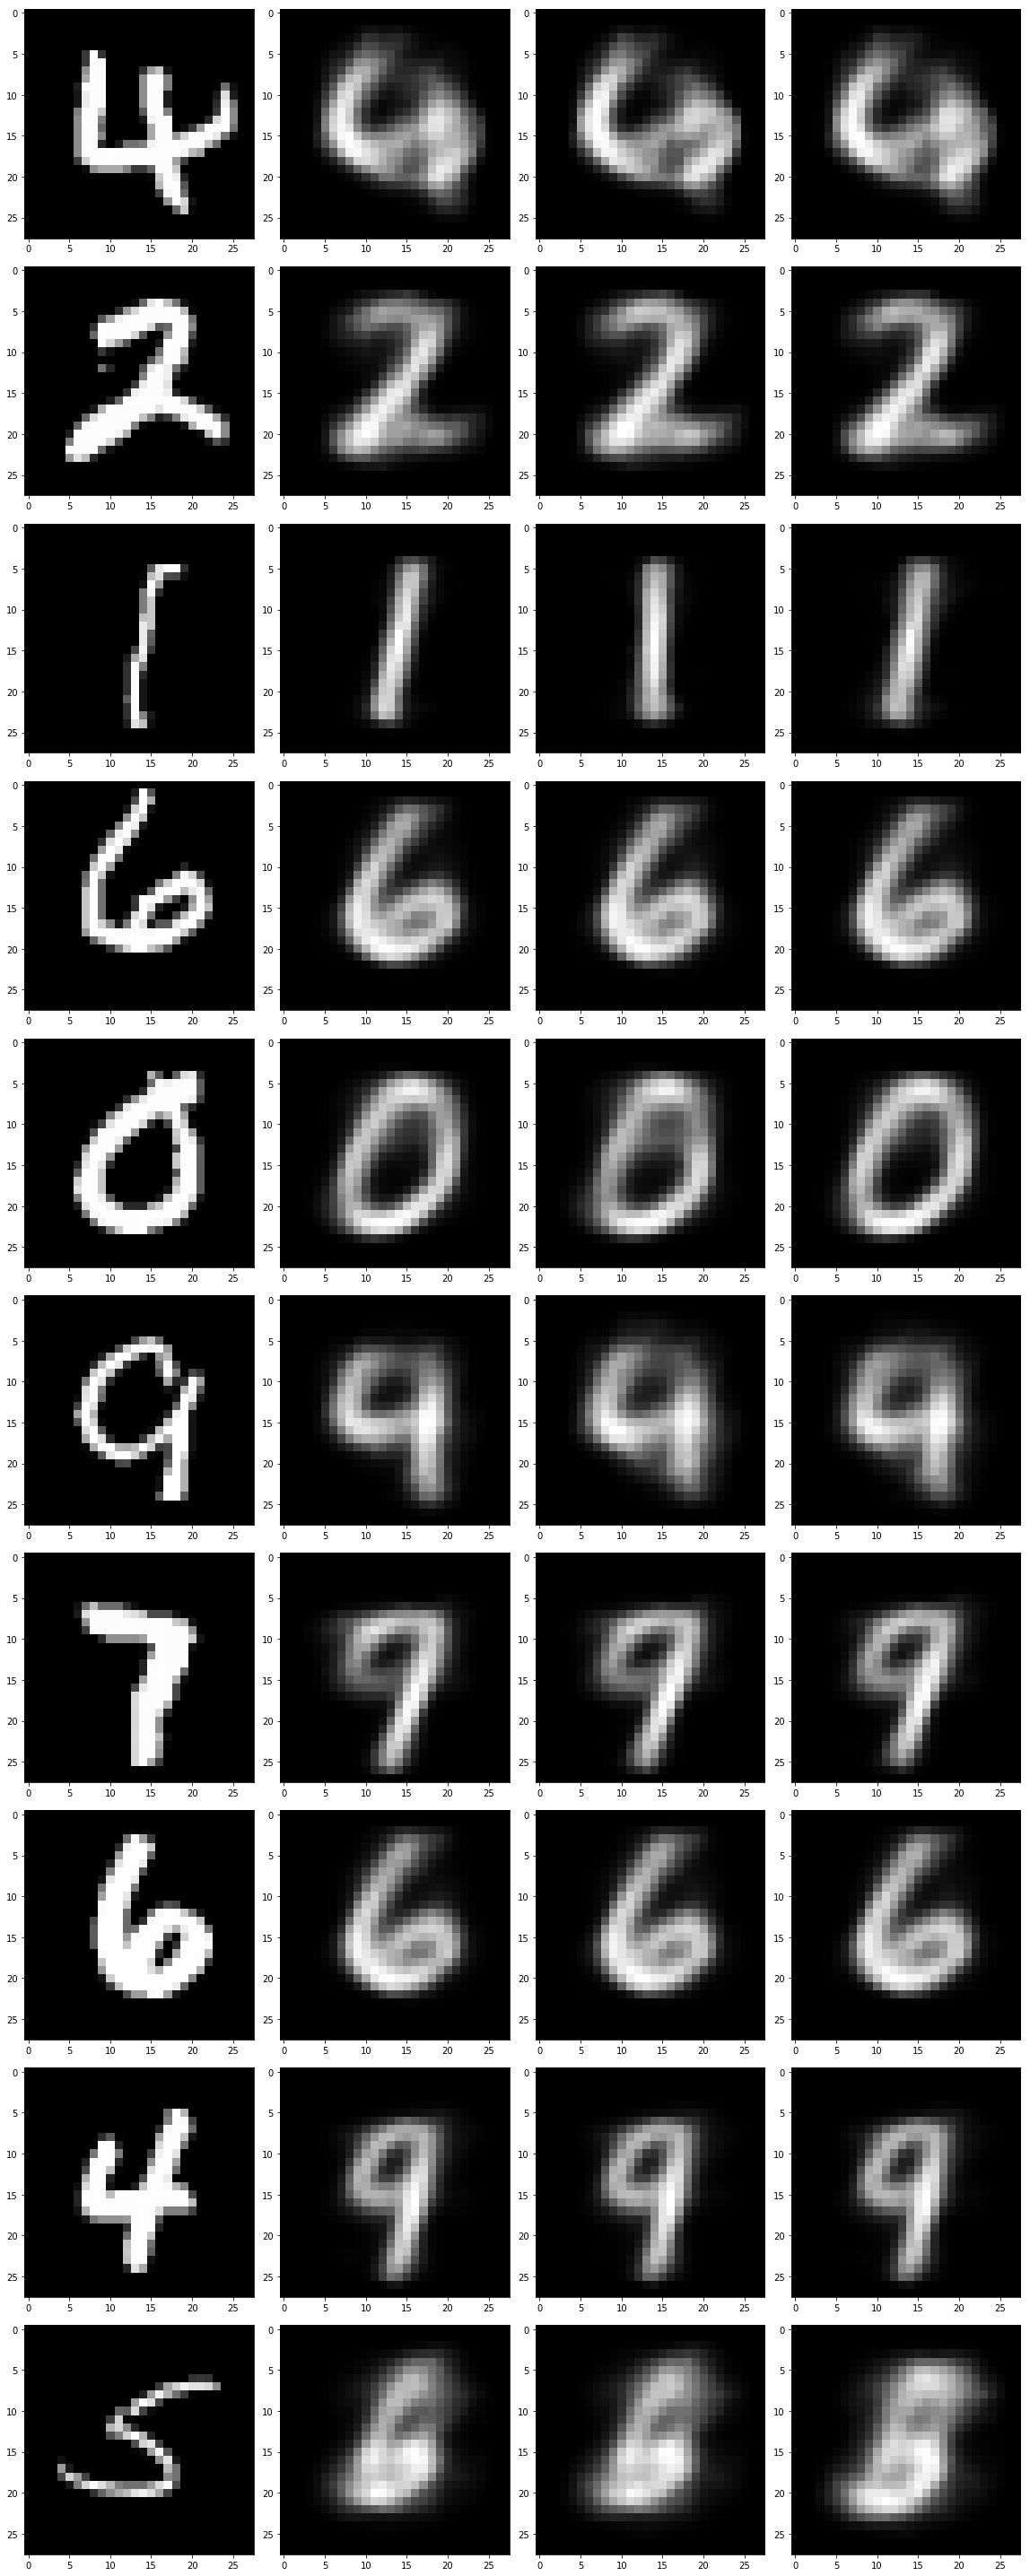

In [8]:
n_examples = 10
n_decoded = 3
fig,ax = plt.subplots(n_examples,1+n_decoded,figsize=(4+4*n_decoded,n_examples*4))

model.cpu()

for i in range(n_examples):
    idx = np.random.randint(len(test_set))

    img = test_set[idx][0]
    ax[i][0].imshow( img.data.numpy().reshape(28,28) ,cmap='gray')

    for dec_i in range(n_decoded):
        decoded = model(img)[0].data.numpy()
    
        ax[i][1+dec_i].imshow( decoded.reshape(28,28) ,cmap='gray')
        
plt.tight_layout()
plt.show()

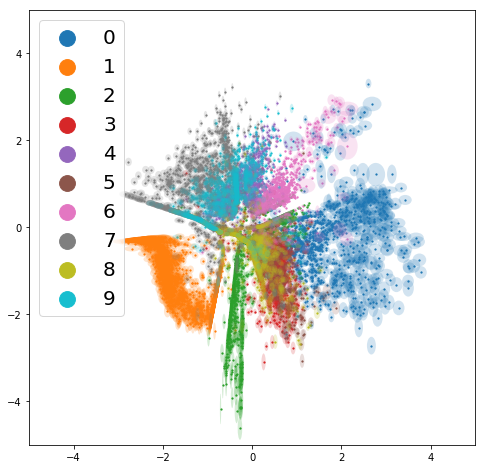

In [9]:
encoding = {}
encoding_std = {}

n_test = len(test_set)

for test_i in range(n_test):
    x,y = test_set[test_i]
    
    if y not in encoding:
        encoding[y] = []
        encoding_std[y] = []
        
    enc_mean, enc_std = model.enc(x.view(-1, 784))
    
    encoding[y].append( enc_mean.data.numpy()[0] )
    encoding_std[y].append( np.exp(0.5*enc_std.data.numpy()[0]) )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])
    encoding_std[key] = np.array(encoding_std[key])
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(figsize=(8,8))

for key in range(10):
    sct = ax.scatter(encoding[key][:,0],encoding[key][:,1],label=str(key),s=1.5)
    for p in zip(encoding[key], encoding_std[key]):
        el = Ellipse(xy=p[0],width=p[1][0],height=p[1][1],angle=0)
        el.set_facecolor(sct.get_facecolor()[0])
        el.set_alpha(0.2)
        ax.add_artist(el)
        
        
lgnd = ax.legend(fontsize=20)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [250]


ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()